## 2. Image Display
We import the necessary packages:

In [2]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
import gc

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
import lsst.geom as geom

### 2.1 Define functions and parameters
Matplotlib stores the data array corresponding to the images it plots, which can eventually cause the kernel to die because of a memory overflow. To mitigate that issue somewhat, we define the following function to cleanup:

In [3]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint. 
    This function was taken from the notebook DP02_03a at data.lsst.cloud

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

We need to set the backend we are going to use (matplotlib)

In [4]:
afwDisplay.setDefaultBackend('matplotlib')

We can also tweak the parameters of matplotlib.pyplot, for example, we can make the font size a little bigger and set a style that is colorblind friendly:

In [5]:
plt.style.use('tableau-colorblind10')
%matplotlib inline

In [6]:
params = {'axes.labelsize': 22,
          'font.size': 22,
          'legend.fontsize': 22,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

Now we can create another instance of the butler, retrieve a coadd and visualize it:


In [7]:
video='u/ir-shir1/DRP/videoCoaddDetect/20221130T131608Z'
butler = Butler('/data/butler/dmu4', collections=video)

In [8]:
my_deepCoadd = butler.get('deepCoadd_calexp', band='Z', tract=8525, patch=70, skymap='hscPdr2')

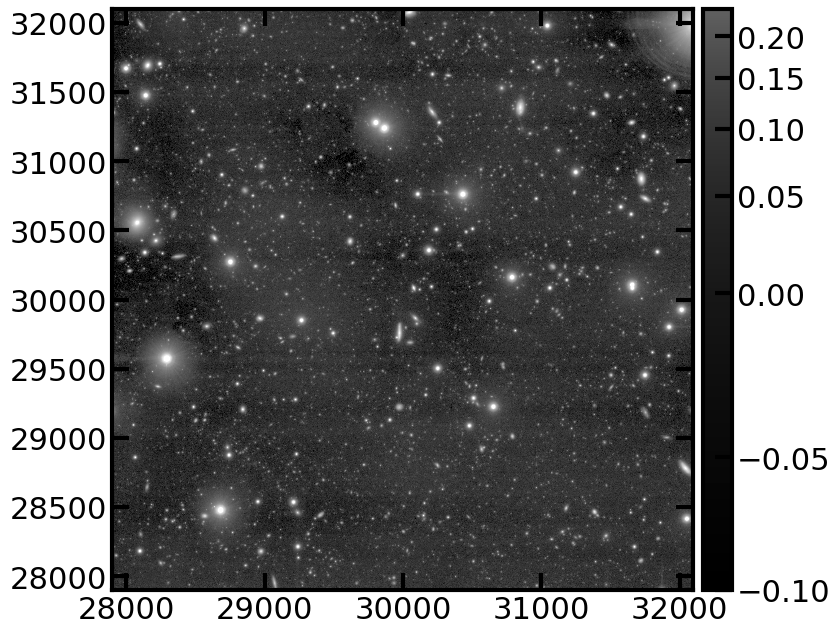

In [9]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(my_deepCoadd.image)
plt.show()
remove_figure(fig)

### 2.2 Change axes to sky coordinates
To see the image axes in sky coordinates instead of pixel coordinates, a simple option is to use astropy's World Coordinate System (WCS) package, along with matplotlib.pyplot's `subplot`, `imshow`, and `grid` functions. 
To do this, we:
1. Set the figure's projection to be the WCS of  `my_deepCoadd`.
2. Define the extent in pixel coordinates using the bounding box.
3. Display the calexp image data array using the gray colormap (cmap) and use approximately the same min and max scale values as above.
4. Add solid white grid lines.
5. Label the axes, and show the plot.
6. Remove the underlying data from memory.

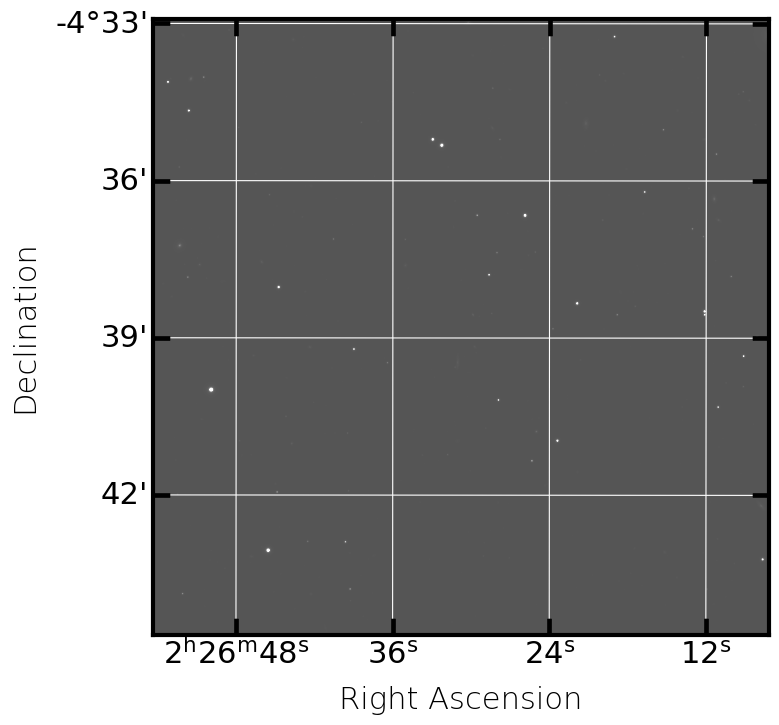

In [10]:
fig = plt.figure()
plt.subplot(projection=WCS(my_deepCoadd.getWcs().getFitsMetadata()))
my_deepCoadd_extent = (my_deepCoadd.getBBox().beginX, my_deepCoadd.getBBox().endX,
                 my_deepCoadd.getBBox().beginY, my_deepCoadd.getBBox().endY)
im = plt.imshow(my_deepCoadd.image.array, cmap='gray', vmin=-200.0, vmax=400,
                extent=my_deepCoadd_extent, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()
remove_figure(fig)

### 2.3 Visualize the image and mask plane
The `afwDisplay` package maps each bit in the mask plane to a specific display color. 
We can view this mapping using the code in the following cell. 
We can also use the `setMaskPlaneColor` method to change the colors that `afwDisplay` uses for each mask plane.

In [11]:
print("Mask plane bit definitions:\n", display.getMaskPlaneColor())
print("\nMask plane methods:\n")
help(display.setMaskPlaneColor)

Mask plane bit definitions:
 {'BAD': 'red', 'CR': 'magenta', 'EDGE': 'yellow', 'INTERPOLATED': 'green', 'SATURATED': 'green', 'DETECTED': 'blue', 'DETECTED_NEGATIVE': 'cyan', 'SUSPECT': 'yellow', 'NO_DATA': 'orange', 'INTRP': 'green', 'SAT': 'green'}

Mask plane methods:

Help on method setMaskPlaneColor in module lsst.afw.display.interface:

setMaskPlaneColor(name, color=None) method of lsst.afw.display.interface.Display instance
    Request that mask plane name be displayed as color
    
    Parameters
    ----------
    name : `str` or `dict`
        Name of mask plane or a dictionary of name -> colorName
    color : `str`
        The name of the color to use (must be `None` if ``name`` is a `dict`)
    
        Colors may be specified as any X11-compliant string (e.g. `"orchid"`), or by one
        of the following constants in `lsst.afw.display` : `BLACK`, `WHITE`, `RED`, `BLUE`,
        `GREEN`, `CYAN`, `MAGENTA`, `YELLOW`.
    
        If the color is "ignore" (or `IGNORE`) then

Let's plot the image and mask plane side-by-side using matplotlib subplots

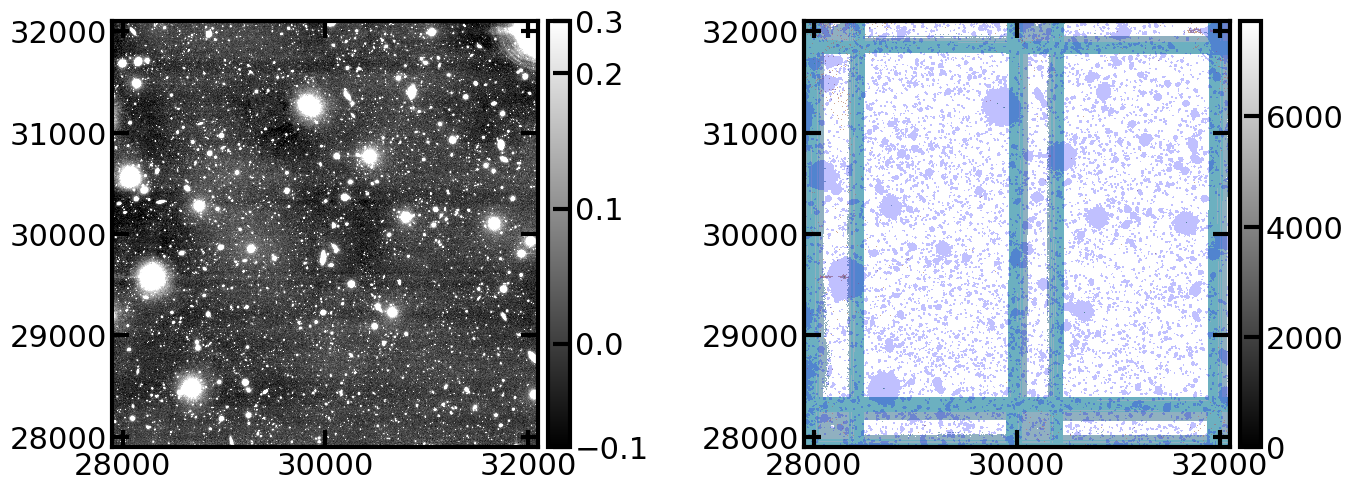

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.sca(ax[0])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(my_deepCoadd.image)
plt.sca(ax[1])
display2 = afwDisplay.Display(frame=fig)
display2.mtv(my_deepCoadd.mask)
plt.tight_layout()
plt.show()
remove_figure(fig)

We can also plot the mask on top of the image:

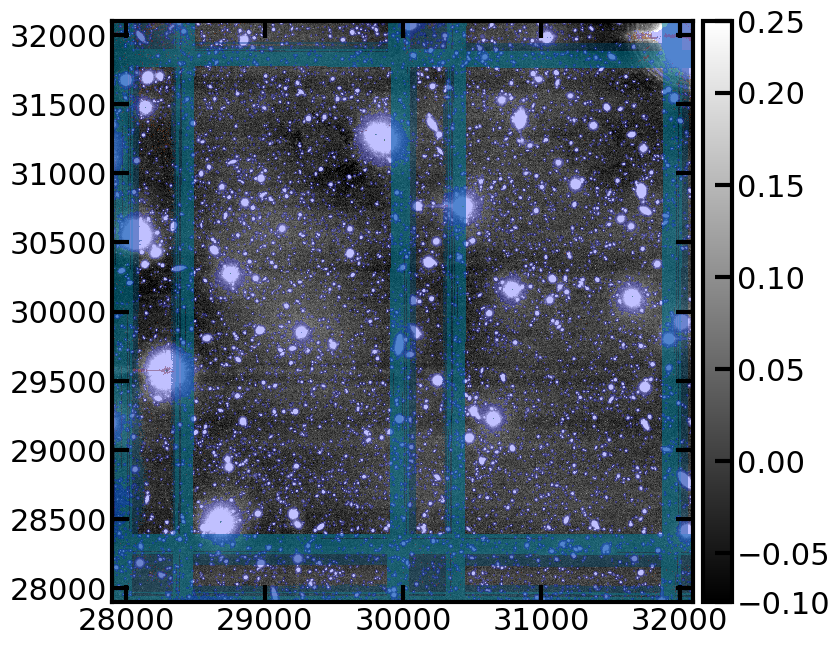

In [13]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('linear', 'zscale')
display.mtv(my_deepCoadd.maskedImage)
plt.show()
remove_figure(fig)

To investigate the mask in a bit more detail, we can add some modifications.

1.We explicitly set the transparency of the overplotted mask (as a percentage: 0 = opaque, 100 = transparent)
2.We explicitly set the color of the 'DETECTED' mask plane to 'red' (i.e., all pixels associated with detected objects).

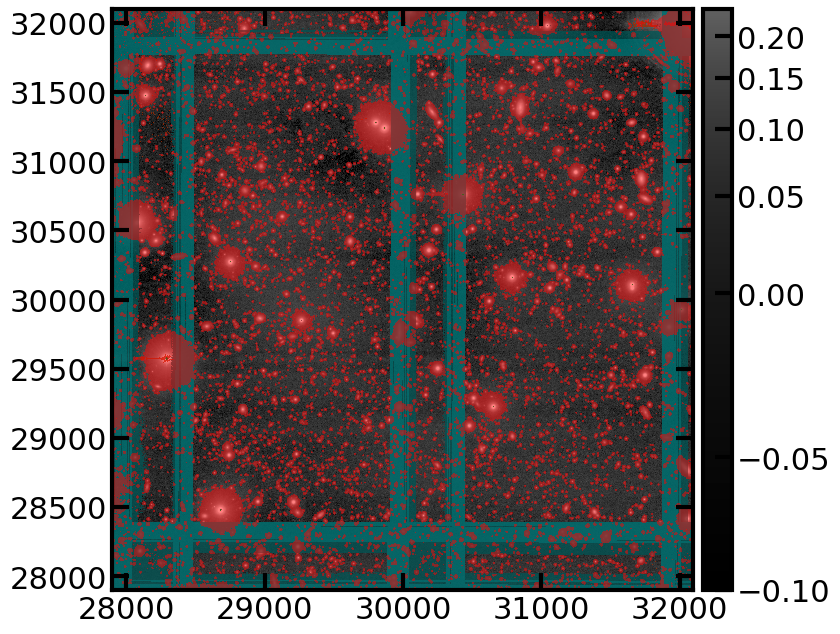

In [15]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.setMaskTransparency(50)
display.setMaskPlaneColor('DETECTED', 'red')
display.mtv(my_deepCoadd)
plt.show()
remove_figure(fig)